In [ ]:
from build.code_quality_visualizer import plot_file_code_quality

plot_file_code_quality("lib/matplotlib/pyplot.py", "matplotlib", ["pylint_score", "mi"])

In [ ]:
from build.code_quality_visualizer import plot_repo_code_quality_fast

plot_repo_code_quality_fast("matplotlib", "2017")

In [ ]:
# TODO Finish coding and testing method when needed
from matplotlib.colors import hex2color
from build.code_quality_analyzer import calculate_maintainability_index, get_attribute_value_at_time
from build.database_handler import get_object
from datetime import datetime
from matplotlib import pyplot as plt

def plot_pull_request_code_quality(pull_request_id, collection, metric_names=[]):
    """
    Plot the code quality metrics for a specific pull request in the repository
    Args:
        pull_request_id (str): The ID of the pull request to plot the code quality metrics for
        collection (str): The name of the collection (i.e., repository) to get the metrics from.
        metric_names (list, optional): The list of metric names to include in the plot
    """
    if metric_names == []:
        print("No metric names provided, using only loc")
        metric_names = ["sloc"]

    pull_request = get_object(pull_request_id, collection)
    if not pull_request:
        print(f"Pull request with ID {pull_request_id} not found in collection {collection}.")
        return
    metrics = {}
    input_metrics = []
    if "mi" in metric_names:
        input_metrics = (["cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"] + metric_names) # TODO Fix error where MI is in wrong order
    else: 
        input_metrics = metric_names
    default_metric_structure = {}
    for metric in input_metrics:
        default_metric_structure[metric] = None

    for relationship in pull_request["relationships"]:
        commit, file_object = None, None
        if relationship["qualifier"] == "formalises":
            commit = get_object(relationship["qualifier"], collection)
        elif relationship["qualifier"] == "aggregates":
            file_object = get_object(relationship["qualifier"], collection)
        if commit is not None and len(commit["attributes"]) > 0:
            commit_time = datetime.fromisoformat(commit["attributes"][0]["time"]).replace(tzinfo=None)
            metrics[commit_time] = default_metric_structure.copy()
        else:
            commit_time = datetime.now() # TODO Test if code can actually show wrong time

        if file_object is not None and file_object["_id"].find(".py") != -1:
            for metric, metric_value in metrics[commit_time].items():
                if metric_value is None and metric != "mi":
                    metrics[commit_time][metric] = get_attribute_value_at_time(file_object["_id"], metric, commit_time, collection) 
                elif metric == "mi":
                    if all(metrics[commit_time][m] is not None for m in input_metrics if m != "mi"):
                        metrics[commit_time][metric] = calculate_maintainability_index(
                            metrics[commit_time]["N_1"],
                            metrics[commit_time]["N_2"],
                            metrics[commit_time]["theta_1"],
                            metrics[commit_time]["theta_2"],
                            metrics[commit_time]["cc"],
                            metrics[commit_time]["sloc"]
                        )/100
                    else: 
                        print(f"ERROR: Not all required metrics for MI calculation are available at {commit_time}.")
            # Get all files modified in all commits and then create average of metrics for files per commit
    
    plt.figure(figsize=(12, 6))
    plt.xlabel("Commit Date")
    plt.ylabel("Code Quality Score")
    plt.title(f"Code Quality Metrics Over Time for PR#{pull_request['_id']}")
    plt.ylim(0, 1.1)

    plt.legend()
    plt.show()

plot_pull_request_code_quality("30348", "matplotlib", ["pylint_score", "mi", "cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"])

In [ ]:
# Start point for testing pull request related viualisations
from build.database_handler import get_pull_requests

collection = "matplotlib"

pull_requests = get_pull_requests(collection)
ids = [pull_request["_id"] for pull_request in pull_requests]

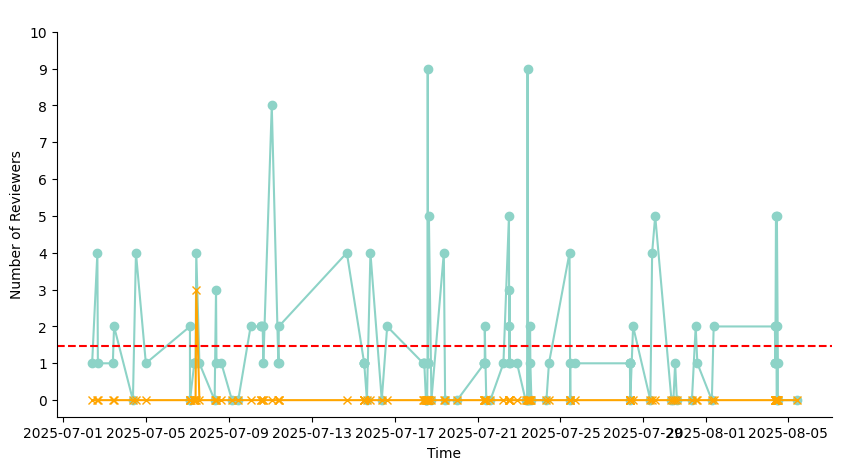

In [6]:
from build.contribution_process_analyzer import pull_request_reviewer_analysis

pull_request_reviewer_analysis(ids, collection, True)

<Figure size 1000x500 with 0 Axes>

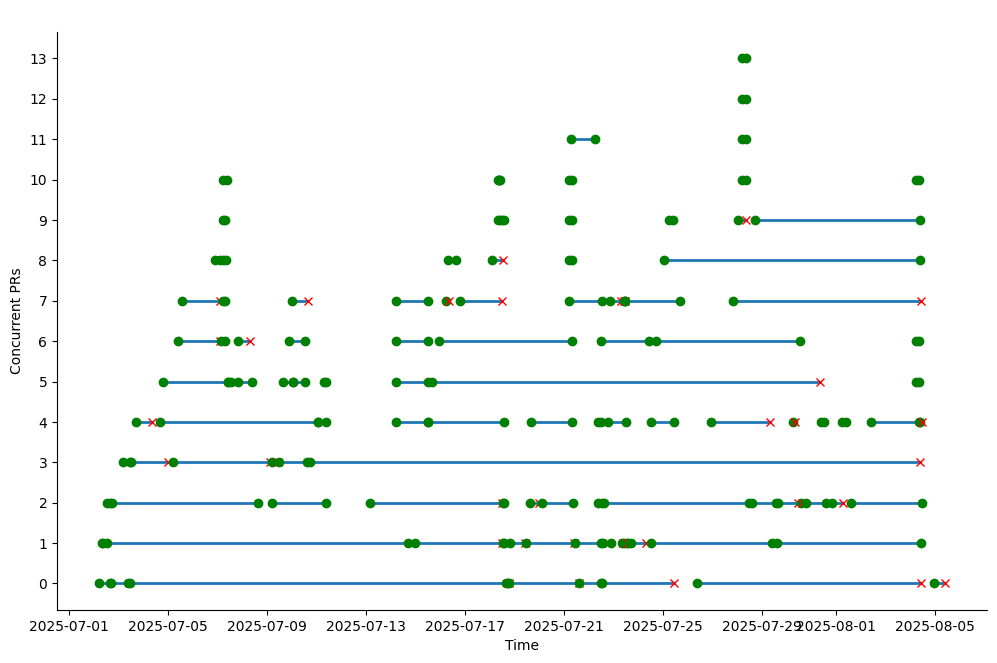

In [5]:
from build.contribution_process_analyzer import pull_request_open_time_analysis

pull_request_open_time_analysis(ids, collection, True)

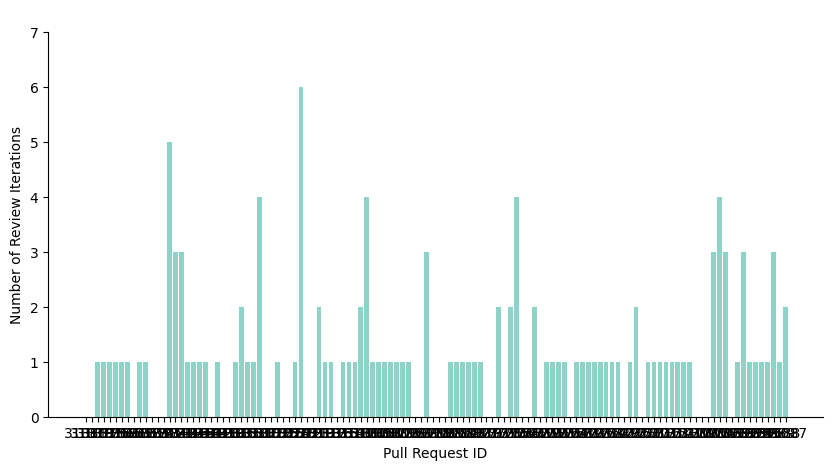

In [4]:
from build.contribution_process_analyzer import pull_request_review_iterations

pull_request_review_iterations(ids, collection, True)

/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/Bachelor-Code/build/contribution_process_analyzer.py:312: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


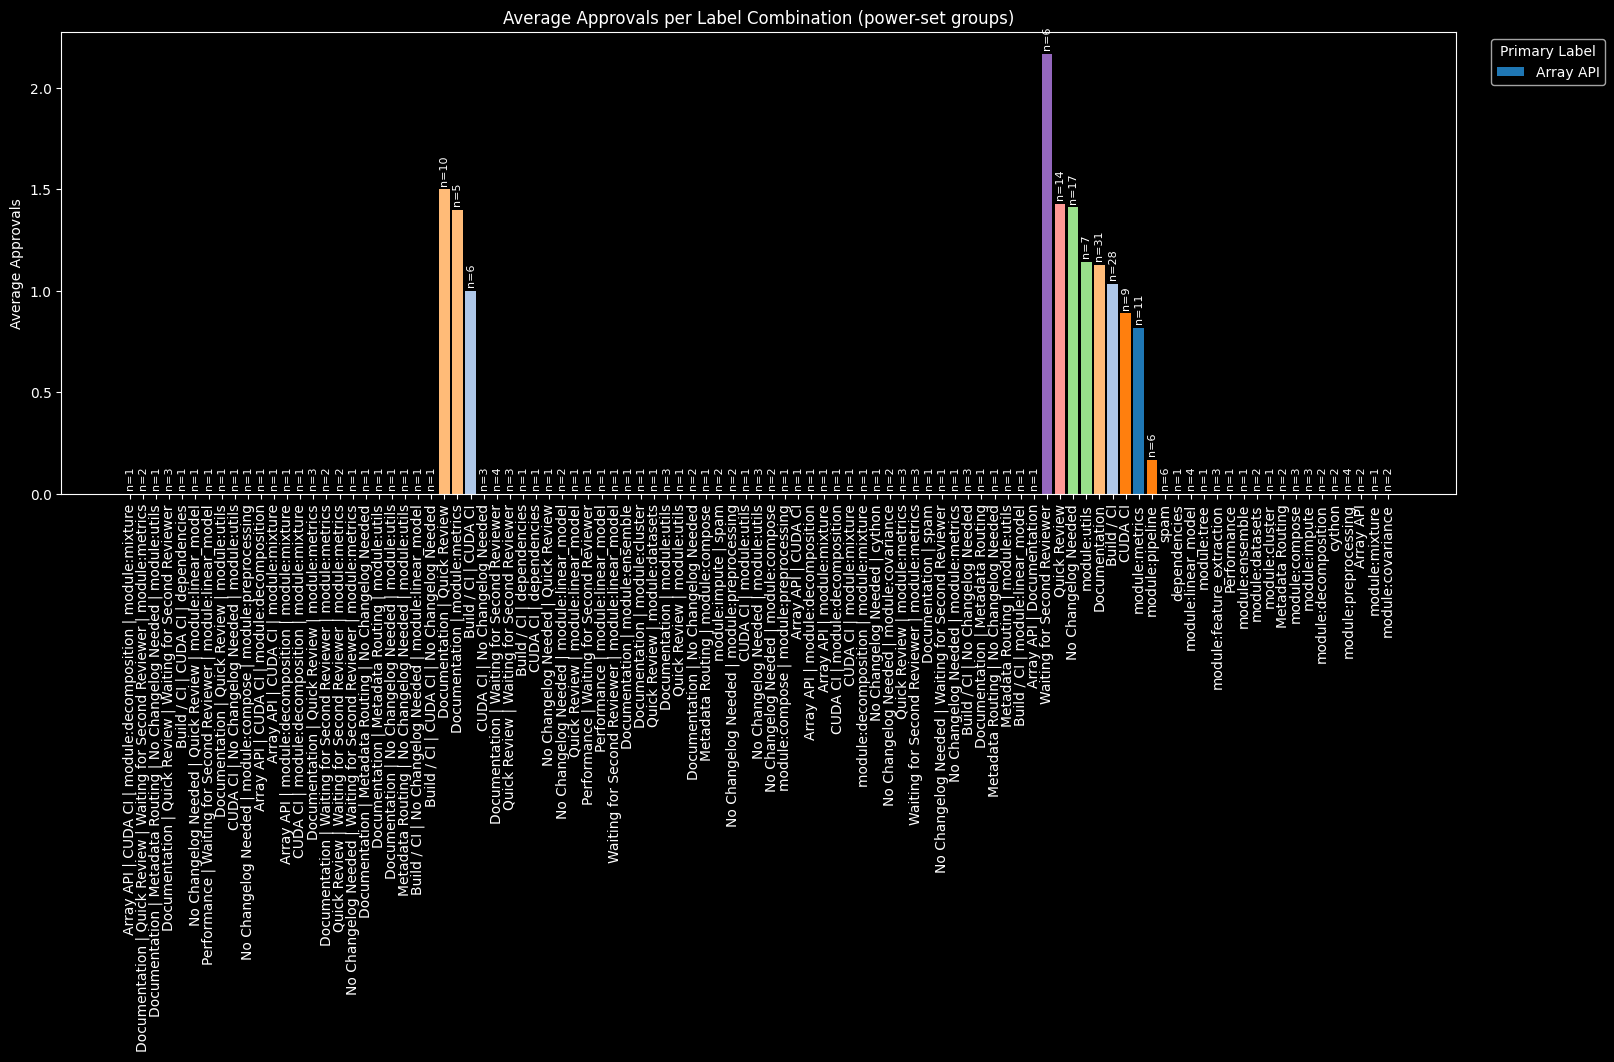

In [3]:
from build.contribution_process_analyzer import pull_request_approving_reviews, pull_request_approving_reviews_grouped
# pull_request_approving_reviews(ids, collection, True)
pull_request_approving_reviews_grouped(ids, collection, True, 5)

In [ ]:
from build.contribution_process_analyzer import pull_request_bot_ratio

pull_request_bot_ratio(ids, collection)

In [8]:
import json
from build.contribution_process_miner import flatten_ocel2
from build.database_handler import get_ocel_data

collection = "matplotlib"

path = get_ocel_data(collection)

with open(path) as f:
    ocel = json.load(f)

res = flatten_ocel2(ocel, "pull_request", collection)